In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys
import warnings

warnings.filterwarnings("ignore")

# Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelling
# Classification
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest

# Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model Selection
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import f1_score

# Visualization
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

## Data Preprocessing

First, basic data preprocessing to obtain accepted and rejected training and test samples separately. Save rejected data in two versions: with and without lables. The rejected data without labels is needed for the semi-supervised model. The rejected data without labels is needed to perform evaluation. 

In [3]:
def data_preprocessing(df, accepted_flag, target, train_ratio):
    """
    The goal of this function is to load the original dataset, split it into accepts and rejects,
    add ids, which can later be used for merging. For the rejects to further perform train / test split

    Parameters
    ----------

    df : name of the original dataset in quotation marks, csv format
    accepted_flag: name of the accepted flag; Binary: 1 if accepted, 0 if rejected
    target : name of the target column
    train_ratio : percentage used for training; Continuous (0,1)

    Return
    ------
    a : accepted data
    r : rejected data
    r_dev : rejected trainining data without label
    r_test : rejected testing data without label
    dfr_dev_with_label: rejected training data with label
    dft_test_with_label: rejected training data with label

    """
    # Load data
    data = pd.read_csv("C:/Users/Asus/Desktop/Repo/MasterThesis_RI/Data_19_05/" + df)

    # Accepted

    ## Create separate dataset with accepts
    dfa = data[data[accepted_flag] == 1]
    dfa = dfa.drop([accepted_flag], axis=1)
    ## Rename target variable as "target"
    dfa = dfa.rename(columns={target: "target"})
    ## Add id to the dataset, which can later be used for merging
    # dfa["id"] = dfa.index.to_series().map(lambda x: uuid.uuid4())

    # Rejected

    ## Create separate dataset with accepts
    dfr = data[data[accepted_flag] == 0]
    dfr = dfr.drop([accepted_flag], axis=1)
    ## Add id to the dataset, which can later be used for merging
    #     dfr["id"] = dfr.index.to_series().map(lambda x: uuid.uuid4())
    ## Train/Test Split (without labels)
    ### Shuffle the dataset
    shuffle_df = dfr.sample(frac=1, random_state=42)
    ### Define a size for the train set
    train_size = int(train_ratio * len(shuffle_df))
    ### Split the dataset
    dfr_dev = shuffle_df[:train_size]
    dfr_test = shuffle_df[train_size:]
    ## Save a copy of the rejected data with label
    dfr_dev_with_label = dfr_dev
    dfr_test_with_label = dfr_test
    ## Unlabel the rejects (i.e. drop the target) and save a copy of the rejeted data without label
    dfr_dev2 = dfr_dev_with_label.drop([target], axis=1)
    dfr_test2 = dfr_test_with_label.drop([target], axis=1)
    # Rename target variable
    dfr_dev_with_label = dfr_dev_with_label.rename(columns={target: "target"})
    dfr_test_with_label = dfr_test_with_label.rename(columns={target: "target"})

    return dfr_dev_with_label, dfr_test_with_label, dfa, dfr, dfr_dev2, dfr_test2

<IPython.core.display.Javascript object>

In [4]:
dfr_dev_with_label, dfr_test_with_label, a, r, r_dev, r_test = data_preprocessing(
    "cons_scen4_1.csv", "is_accepted", "y", 0.8
)

<IPython.core.display.Javascript object>

The below two functions continue the data preprocessing. Used to create feature and target data and to split into train and test samples.

In [5]:
def create_X_y(data):
    """
    Undersample the data

    Parameters
    ----------
    data : Dataframe

    Return
    ------
    X_res : undersampled data; Dataframe
    y_res : undersampled labels; Dataframe

    """
    # Create X and y
    X = data.loc[:, data.columns != "target"]
    y = data.loc[:, data.columns == "target"]

    return X, y

<IPython.core.display.Javascript object>

In [6]:
def split(X, y):
    """
    Split the data into training and testing sample

    Parameters
    ----------
    X : data
    y : labels

    Return
    ------
    X_train : training modelling fields
    X_test : test modelling fields
    y_train : training labels
    y_test : testing labels

    """
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.2, random_state=7
    )
    columns = X_train.columns

    # Columns
    X_train = pd.DataFrame(data=X_train, columns=columns)
    y_train = pd.DataFrame(data=y_train, columns=["target"])

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

In [7]:
X_res, y_res = create_X_y(a)
X_train, X_test, y_train, y_test = split(X_res, y_res)
dfr_test_with_label_X = dfr_test_with_label.loc[:, dfr_test_with_label.columns != "y"]
dfr_test_with_label_y = dfr_test_with_label.loc[:, dfr_test_with_label.columns == "y"]

<IPython.core.display.Javascript object>

## Feature Selection

First, we select the features that will end up in the model. The selection of columns below is subject to iteration based on the modelling outcomes from the logistic regression, i.e. significance (p-values).

In [8]:
significant_columns = [
    "known_col_0",
    "known_col_1",
    "known_col_3",
    "known_col_4",
]

<IPython.core.display.Javascript object>

In [9]:
# Primary datasets
X_train = X_train[significant_columns]
X_test = X_test[significant_columns]
r_dev = r_dev[significant_columns]
r_test = r_test[significant_columns]

<IPython.core.display.Javascript object>

In [10]:
# Build Logistic regression
# Statmodels
X_in = sm.add_constant(X_train.astype(float))
logit_model = sm.Logit(y_train, X_in)
result3 = logit_model.fit()
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.058502
         Iterations 12
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.826    
Dependent Variable: target           AIC:              1507.6555
Date:               2021-05-19 23:52 BIC:              1544.9415
No. Observations:   12800            Log-Likelihood:   -748.83  
Df Model:           4                LL-Null:          -4295.6  
Df Residuals:       12795            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     12.0000                                     
----------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------
const        -13.3127   0.4849 -27.4539 0.0000 -14.2631 -12.3623
known_col_0   -1.8920   0.0970 -19.4977 0.0000  -2.0822  -1.7018
known_col_1 

<IPython.core.display.Javascript object>

In [11]:
# Calculate Default Rates
dr = len(y_test[y_test["target"] == 1]) / (
    len(y_test[y_test["target"] == 1]) + len(y_test[y_test["target"] == 0])
)
conservative_dr = (
    1.1
    * len(y_test[y_test["target"] == 1])
    / (len(y_test[y_test["target"] == 1]) + len(y_test[y_test["target"] == 0]))
)

<IPython.core.display.Javascript object>

## Isolation Forest

For rejects, another step of data preporcessing is applied via Isolation Forest model. The goal is to remove outliers. The isolation forest is trained on all accepts and is used to evaluate the similarity of the rejects. Then the rejects that are found to be the most and least similar to the accepts are dropped. The contaimination parameter determines how many observations are excluded.

In [12]:
# def isolation_forest(X_train, r_dev, r_test):
#     """
#     The goal of this function is to filter the outliers from the rejected sample.

#     Parameters
#     ----------
#     X_train: accepts training data; Dataframe
#     r_dev_mod: rejects modelling data prior outlier treatment; Dataframe
#     r_test_mod: rejects testinf data prior outlier treatment; Dataframe

#     Return
#     ------
#     r_dev_mod: rejects modelling data post outlier treatment; Dataframe
#     r_test_mod: rejects training data prior outlier treatment; Dataframe

#     """

#     # Build Isolation forest model
#     isf = IsolationForest(
#         n_estimators=50,
#         max_samples="auto",
#         contamination=float(0.005),
#         max_features=1.0,
#     )
#     isf.fit(X_train)
#     rej_isf = isf.predict(r_dev)
#     # Add scores and anomaly columns to rejected train
#     r_dev["scores"] = isf.decision_function(r_dev)
#     r_dev["anomaly"] = isf.predict(r_dev[significant_columns])
#     # Print number of non-outliers and outliers
#     print("Rejected Train. Number of non-outliers is:", np.sum(r_dev["anomaly"] == 1))
#     print("Rejected Train. Number of outliers is:", np.sum(r_dev["anomaly"] == -1))
#     # Drop all outliers
#     r_dev = r_dev[r_dev.anomaly != -1]
#     # Delete columns related to the outliers
#     r_dev = r_dev[significant_columns]

#     # Add scores and anomaly columns to rejected test
#     r_test["scores"] = isf.decision_function(r_test)
#     r_test["anomaly"] = isf.predict(r_test[significant_columns])
#     # Print number of non-outliers and outliers
#     print("Rejected Test. Number of non-outliers is:", np.sum(r_test["anomaly"] == 1))
#     print("Rejected Test. Number of outliers is:", np.sum(r_test["anomaly"] == -1))
#     # Drop all outliers
#     r_test = r_test[r_test.anomaly != -1]
#     # Delete columns related to the outliers
#     r_test = r_test[significant_columns]

#     return r_dev, r_test

<IPython.core.display.Javascript object>

In [13]:
# r_dev, r_test = isolation_forest(X_train, r_dev, r_test)

<IPython.core.display.Javascript object>

## Self Training for the Most Certain examples with Max F1 score as stopping criteria

In [14]:
# Create copies of the data that can be overwritten in the function below
X_train_iter = X_train.copy()
y_train_iter = y_train.copy()
r_dev_iter = r_dev.copy()

<IPython.core.display.Javascript object>

In [15]:
# Add more scores that you want to track
f1_scores = []
iterations = []
# log_losses = []

for iteration in range(1, 25):  # Change to how many iterrations you like
    print("Iteration Nr {}".format(iteration))
    # Build logistic regression
    KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(
        X_train_iter, y_train_iter
    )
    # KGB1 = RandomForestClassifier().fit(X_train_iter, y_train_iter)
    f1_stat = f1_score(KGB1.predict(X_test), y_test, average="weighted")
    f1_scores.append(f1_stat)

    #     logloss = log_loss(KGB1.predict(X_test), y_test, eps=1e-15)
    #     log_losses.append(log_losses)
    print("F1: ", f1_stat)
    # print("Log Loss: ", logloss)
    # Make predictions on the rejected data
    pred = KGB1.predict_proba(r_dev_iter)[:, 1]
    pred = pd.DataFrame(
        data=pred,
        columns=["target"],
        index=r_dev_iter.index.copy(),
    )

    # Choose the most certain predictions
    lq = pred["target"].quantile(q=0.05)
    uq = pred["target"].quantile(q=0.95)
    pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

    # If PD is high, apply default status
    pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

    # Pick only the certain predictions and concatenate them to the dev set
    # Y TRAIN
    certain = pred[pred["certain"] == 1]
    certain2 = certain["target"].to_frame()
    y_train_iter = pd.concat((y_train_iter, certain2))

    # Get significant columns of the rejects based on index
    certain_features = pd.merge(
        certain["target"],
        r_dev_iter[significant_columns],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # X TRAIN
    certain_features = certain_features.loc[:, certain_features.columns != "target"]
    X_train_iter = pd.concat((X_train_iter, certain_features))

    # Remove certain columns from rejected data
    rows = certain_features.index
    r_dev_iter = r_dev_iter.drop(rows, axis="index")

Iteration Nr 1
F1:  0.5221053350386908
Iteration Nr 2
F1:  0.5217587257899915
Iteration Nr 3
F1:  0.5224520429420242
Iteration Nr 4
F1:  0.5224520429420242
Iteration Nr 5
F1:  0.5221053350386908
Iteration Nr 6
F1:  0.5224520429420242
Iteration Nr 7
F1:  0.5221053350386908
Iteration Nr 8
F1:  0.5214122153033838
Iteration Nr 9
F1:  0.5217587257899915
Iteration Nr 10
F1:  0.5214122153033838
Iteration Nr 11
F1:  0.5207194910463432
Iteration Nr 12
F1:  0.5196811480637039
Iteration Nr 13
F1:  0.5196811480637039
Iteration Nr 14
F1:  0.5196811480637039
Iteration Nr 15
F1:  0.5196811480637039
Iteration Nr 16
F1:  0.5203732774908939
Iteration Nr 17
F1:  0.5196811480637039
Iteration Nr 18
F1:  0.5200271631275051
Iteration Nr 19
F1:  0.5196811480637039
Iteration Nr 20
F1:  0.5203732774908939
Iteration Nr 21
F1:  0.5214122153033838
Iteration Nr 22
F1:  0.5217587257899915
Iteration Nr 23
F1:  0.5217587257899915
Iteration Nr 24
F1:  0.5214122153033838


<IPython.core.display.Javascript object>

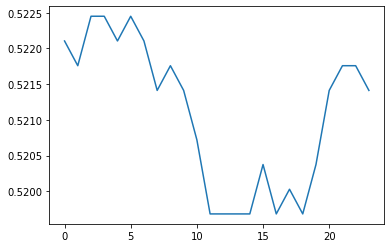

<IPython.core.display.Javascript object>

In [16]:
plt.plot(f1_scores, label="F1 Scores")

In [17]:
# Save the iteration of the model where max score is reached
max_value = max(f1_scores)
max_index = f1_scores.index(max_value)

<IPython.core.display.Javascript object>

### Do only 1 iteration as baseline Model

In [18]:
# Create copies of the data that can be overwritten in the function below
X_train_iter1 = X_train.copy()
y_train_iter1 = y_train.copy()
r_dev_iter1 = r_dev.copy()

<IPython.core.display.Javascript object>

In [19]:
# Add more scores that you want to track
f1_scores = []
iterations = []
# log_losses = []

for iteration in range(1, 2):  # Change to how many iterrations you like
    print("Iteration Nr {}".format(iteration))
    # Build logistic regression
    KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(
        X_train_iter1, y_train_iter1
    )
    # KGB1 = RandomForestClassifier().fit(X_train_iter1, y_train_iter1)
    f1_stat = f1_score(KGB1.predict(X_test), y_test, average="weighted")
    f1_scores.append(f1_stat)

    #     logloss = log_loss(KGB1.predict(X_test), y_test, eps=1e-15)
    #     log_losses.append(log_losses)
    print("F1: ", f1_stat)
    # print("Log Loss: ", logloss)
    # Make predictions on the rejected data
    pred = KGB1.predict_proba(r_dev_iter1)[:, 1]
    pred = pd.DataFrame(
        data=pred,
        columns=["target"],
        index=r_dev_iter1.index.copy(),
    )

    # Choose the most certain predictions
    lq = pred["target"].quantile(q=0.05)
    uq = pred["target"].quantile(q=0.95)
    pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

    # If PD is high, apply default status
    pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

    # Pick only the certain predictions and concatenate them to the dev set
    # Y TRAIN
    certain = pred[pred["certain"] == 1]
    certain2 = certain["target"].to_frame()
    y_train_iter1 = pd.concat((y_train_iter1, certain2))

    # Get significant columns of the rejects based on index
    certain_features = pd.merge(
        certain["target"],
        r_dev_iter1[significant_columns],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # X TRAIN
    certain_features = certain_features.loc[:, certain_features.columns != "target"]
    X_train_iter1 = pd.concat((X_train_iter1, certain_features))

    # Remove certain columns from rejected data
    rows = certain_features.index
    r_dev_iter1 = r_dev_iter1.drop(rows, axis="index")

Iteration Nr 1
F1:  0.5221053350386908


<IPython.core.display.Javascript object>

In [20]:
def predict_rejects(model, r_dev):
    # Make predictions on the Train Rejects
    pred_test = model.predict_proba(r_dev)[:, 1]
    pred_test = pd.DataFrame(
        data=pred_test,
        columns=["pred"],
        index=r_dev.index.copy(),
    )

    # Make binary predictions based on cutoff DR
    q1 = pred_test["pred"].quantile(q=1 - conservative_dr)
    pred_test["target"] = pred_test["pred"].apply(lambda x: 0 if (x < q1) else 1)
    pred_test = pred_test["target"].to_frame()

    # Add new rows to df
    y_train_new = pd.concat((y_train, pred_test))
    X_train_new = pd.concat((X_train, r_dev))

    # Fit new model
    KGB_baseline_new = LogisticRegression(fit_intercept=False, penalty="none").fit(
        X_train_new, y_train_new
    )
    #     KGB_baseline_new = RandomForestClassifier().fit(X_train_new, y_train_new)
    return KGB_baseline_new

<IPython.core.display.Javascript object>

In [21]:
def evaluate_test_accepts(model, X_test):
    pred_test = model.predict_proba(X_test)[:, 1]
    pred_test = pd.DataFrame(
        data=pred_test,
        columns=["pred"],
        index=X_test.index.copy(),
    )

    # Merge with Target
    pred_test2 = pd.merge(
        pred_test["pred"],
        y_test["target"],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # Make binary predictions based on cutoff 50percentile of the distribution
    q1 = pred_test2["pred"].quantile(q=1 - conservative_dr)
    pred_test2["prediction_baseline"] = pred_test2["pred"].apply(
        lambda x: 0 if (x < q1) else 1
    )
    return pred_test2

<IPython.core.display.Javascript object>

In [22]:
def evaluate_test_rejects(model, r_test):
    pred_test = model.predict_proba(r_test)[:, 1]
    pred_test = pd.DataFrame(
        data=pred_test,
        columns=["pred"],
        index=r_test.index.copy(),
    )

    # Merge with Target
    pred_test2 = pd.merge(
        pred_test["pred"],
        dfr_test_with_label["target"],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # Make binary predictions based on cutoff 50percentile of the distribution
    q1 = pred_test2["pred"].quantile(q=1 - conservative_dr)
    pred_test2["prediction_baseline"] = pred_test2["pred"].apply(
        lambda x: 0 if (x < q1) else 1
    )
    return pred_test2

<IPython.core.display.Javascript object>

In [23]:
def flag_df_baseline(df):

    # Flag kicked out bad cases (want more of these)
    if df["target"] == 1 and df["prediction_baseline"] == 1:
        return "CB"

    # Flag kicked out good cases (want less of these)
    elif df["target"] == 1 and df["prediction_baseline"] == 0:
        return "IB"

    # Flag kicked in good cases (want more of these)
    elif df["target"] == 0 and df["prediction_baseline"] == 0:
        return "CG"

    # Flag kicked in bad cases (want less of these)
    elif df["target"] == 0 and df["prediction_baseline"] == 1:
        return "IG"

<IPython.core.display.Javascript object>

In [24]:
def kickout_baseline(df):

    # Counts of kickout bad and kickout good
    counts = df["Flag"].value_counts()
    if "CB" in df.values:
        cb = counts.CB  # want more of these
    else:
        cb = 0
    if "IB" in df.values:
        ib = counts.IB  # want less of these
    else:
        ib = 0

    if "CG" in df.values:
        cg = counts.CG  # want more of these
    else:
        cg = 0

    if "IG" in df.values:
        ig = counts.IG  # want less of these
    else:
        ig = 0

    # Target
    total_bads = df[df["target"] == 1].shape[0]
    total_goods = df[df["target"] == 0].shape[0]
    pb = total_bads / (total_bads + total_goods)
    pg = total_goods / (total_bads + total_goods)

    kickout = (((cb / pb) - (ib / pb)) / total_bads) * (pb ** 2)
    kickin = (((cg / pg) - (ig / pg)) / total_goods) * (pg ** 2)
    weighted_total = kickout + kickin
    return weighted_total

<IPython.core.display.Javascript object>

## 1. Prediction before RI

Step 1: KGB Model ($m_{1}$)  <br>
Step 2: Score Test Accepts and Test Rejects

In [25]:
pred_test_a = evaluate_test_accepts(KGB1, X_test)
pred_test_r = evaluate_test_rejects(KGB1, r_test)

<IPython.core.display.Javascript object>

In [26]:
pred_test_a["Flag"] = pred_test_a.apply(flag_df_baseline, axis=1)
predictions_accepts_beforeRI = [round(kickout_baseline(pred_test_a).tolist(), 3)]

<IPython.core.display.Javascript object>

In [27]:
pred_test_r["Flag"] = pred_test_r.apply(flag_df_baseline, axis=1)
predictions_rejects_beforeRI = [round(kickout_baseline(pred_test_r).tolist(), 3)]

<IPython.core.display.Javascript object>

## 2. Predicions Baseline

Step 1: KGB Model ($m_{1}$)  <br>
Step 2: Infer status of each reject <br> 
Step 3: Redevelop KGB mdoel with inferred rejects ($m_{2}$)  <br>
Step 4: Score Test Accepts and Test Rejects

In [28]:
KGB_baseline_new = predict_rejects(KGB1, r_dev)
pred_test_a = evaluate_test_accepts(KGB_baseline_new, X_test)
pred_test_r = evaluate_test_rejects(KGB_baseline_new, r_test)

<IPython.core.display.Javascript object>

In [29]:
pred_test_a["Flag"] = pred_test_a.apply(flag_df_baseline, axis=1)
predictions_accepts_base = [round(kickout_baseline(pred_test_a).tolist(), 3)]

<IPython.core.display.Javascript object>

In [30]:
pred_test_r["Flag"] = pred_test_r.apply(flag_df_baseline, axis=1)
predictions_rejects_base = [round(kickout_baseline(pred_test_r).tolist(), 3)]

<IPython.core.display.Javascript object>

### Retrain with the most optimal Iteration

In [31]:
# Add more scores that you want to track
f1_scores = []
iterations = []
# log_losses = []

for iteration in range(1, max_index + 1):  # Change to how many iterrations you like
    print("Iteration Nr {}".format(iteration))
    # Build logistic regression
    KGB1 = LogisticRegression(fit_intercept=False, penalty="none").fit(X_train, y_train)
    # KGB1 = RandomForestClassifier().fit(X_train, y_train)
    f1_stat = f1_score(KGB1.predict(X_test), y_test, average="weighted")
    f1_scores.append(f1_stat)

    #     logloss = log_loss(KGB1.predict(X_test), y_test, eps=1e-15)
    #     log_losses.append(log_losses)
    print("F1: ", f1_stat)
    # print("Log Loss: ", logloss)
    # Make predictions on the rejected data
    pred = KGB1.predict_proba(r_dev)[:, 1]
    pred = pd.DataFrame(
        data=pred,
        columns=["target"],
        index=r_dev.index.copy(),
    )
    # Choose the most certain predictions
    lq = pred["target"].quantile(q=0.05)
    uq = pred["target"].quantile(q=0.95)
    pred["certain"] = pred["target"].apply(lambda x: 1 if (x < lq or x > uq) else 0)

    # If PD is high, apply default status
    pred["target"] = pred["target"].apply(lambda x: 1 if (x > uq) else 0)

    # Pick only the certain predictions and concatenate them to the dev set
    # Y TRAIN
    certain = pred[pred["certain"] == 1]
    certain2 = certain["target"].to_frame()
    y_train = pd.concat((y_train, certain2))

    # Get significant columns of the rejects based on index
    certain_features = pd.merge(
        certain["target"],
        r_dev[significant_columns],
        how="inner",
        left_index=True,
        right_index=True,
    )

    # X TRAIN
    certain_features = certain_features.loc[:, certain_features.columns != "target"]
    X_train = pd.concat((X_train, certain_features))

    # Remove certain columns from rejected data
    rows = certain_features.index
    r_dev = r_dev.drop(rows, axis="index")

Iteration Nr 1
F1:  0.5221053350386908
Iteration Nr 2
F1:  0.5217587257899915


<IPython.core.display.Javascript object>

## 3. KGB model of best iteration

Step 1: KGB Model ($m_{1}$)  <br>
Step 2: Infer status of each reject <br> 
Step 3: Choose the most certain predictions (0.05q and 0.95q of the predicted probailities) <br>
Step 4: Add the most certain predictions to the training sample
Step 5: Redevelop KGB Model ($m_{2}$)  <br>
Step 6: Repeat Step 5 until convergence - best F1 score ($m_{i}$)  <br> 
Step 7: Score Test Accepts and Test Rejects

In [32]:
pred_test_a = evaluate_test_accepts(KGB1, X_test)
pred_test_r = evaluate_test_rejects(KGB1, r_test)

<IPython.core.display.Javascript object>

In [33]:
pred_test_a["Flag"] = pred_test_a.apply(flag_df_baseline, axis=1)
predictions_accepts_iter = [round(kickout_baseline(pred_test_a).tolist(), 3)]

<IPython.core.display.Javascript object>

In [34]:
pred_test_r["Flag"] = pred_test_r.apply(flag_df_baseline, axis=1)
predictions_rejects_iter = [round(kickout_baseline(pred_test_r).tolist(), 3)]

<IPython.core.display.Javascript object>

## 4. New model

Step 1: KGB Model ($m_{1}$)  <br>
Step 2: Infer status of each reject <br> 
Step 3: Choose the most certain predictions (0.05q and 0.95q of the predicted probailities) <br>
Step 4: Add the most certain predictions to the training sample <br>
Step 5: Redevelop KGB Model ($m_{2}$)  <br>
Step 6: Repeat Step 5 until convergence - best F1 score ($m_{i}$) <br> 
Step 7: Infer status of each reject with ($m_{i}$) <br> 
Step 8: Redevelop KGB mdoel with inferred rejects ($m_{final}$) <br> 
Step 9: Score Test Accepts and Test Rejects

In [35]:
KGB_baseline_new = predict_rejects(KGB1, r_dev)
pred_test_a = evaluate_test_accepts(KGB_baseline_new, X_test)
pred_test_r = evaluate_test_rejects(KGB_baseline_new, r_test)

<IPython.core.display.Javascript object>

In [36]:
pred_test_a["Flag"] = pred_test_a.apply(flag_df_baseline, axis=1)
predictions_accepts_new = [round(kickout_baseline(pred_test_a).tolist(), 3)]

<IPython.core.display.Javascript object>

In [37]:
pred_test_r["Flag"] = pred_test_r.apply(flag_df_baseline, axis=1)
predictions_rejects_new = [round(kickout_baseline(pred_test_r).tolist(), 3)]

<IPython.core.display.Javascript object>

## Combine predictions

In [38]:
my_list_accepts = [
    predictions_accepts_beforeRI,
    predictions_accepts_base,
    predictions_accepts_iter,
    predictions_accepts_new,
]
df_pred_accepts = pd.DataFrame(my_list_accepts).transpose()
df_pred_accepts = df_pred_accepts.rename(
    columns={0: "Before RI", 1: "Baseline", 2: "Iteration n", 3: "Self-Training"},
)

<IPython.core.display.Javascript object>

In [39]:
my_list_rejects = [
    predictions_rejects_beforeRI,
    predictions_rejects_base,
    predictions_rejects_iter,
    predictions_rejects_new,
]
df_pred_rejects = pd.DataFrame(my_list_rejects).transpose()
df_pred_rejects = df_pred_rejects.rename(
    columns={0: "Before RI", 1: "Baseline", 2: "Iteration n", 3: "Self-Training"},
)

<IPython.core.display.Javascript object>

In [40]:
df_pred_accepts

,Before RI,Baseline,Iteration n,Self-Training
0,0.926,0.935,0.926,0.932


<IPython.core.display.Javascript object>

In [41]:
df_pred_rejects

,Before RI,Baseline,Iteration n,Self-Training
0,0.932,0.943,0.932,0.943


<IPython.core.display.Javascript object>

## Parcelling